In [20]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import torch
import torchvision
from abc import ABC
import pickle
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from typing import List
from sklearn import preprocessing
from tqdm import tqdm

tqdm.pandas()
EMB = r"C:\Users\Wilk\PiSR1\data\emb.p"
RATINGS_SMALL = r"C:\Users\Wilk\PiSR1\data\ratings_small.csv"
MOVIES = r"C:\Users\Wilk\PiSR1\data\movies_metadata.csv"
to_drop = ["1997-08-20","2012-09-29","2014-01-01"]
SEED = 42
DEVICE = torch.device("cpu")
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
DEVICE

device(type='cuda')

In [31]:
column_list = ["id","adult","budget","popularity","runtime","vote_average","vote_count","original_language","belongs_to_collection","spoken_languages","genres"]
def getMoviesContentDataset(Embeddings=False):
    movies = pd.read_csv(MOVIES)
    ratings = pd.read_csv(RATINGS_SMALL)
    
    for drop_error in to_drop:
        movies = movies[movies.id != drop_error]
    movies.id = movies.id.astype('int64')
    dataset = ratings.merge(movies[column_list], left_on='movieId', right_on='id')
    
    dataset = dataset.dropna()    
    
    budget_Scaler = preprocessing.StandardScaler().fit(dataset.budget.to_numpy().reshape(-1, 1))
    
    lang_encoder = preprocessing.LabelEncoder().fit(dataset.original_language)
    
    genres_encoder = preprocessing.LabelEncoder().fit(dataset.genres)
    
    spoken_languages_encoder = preprocessing.LabelEncoder().fit(dataset.spoken_languages)
    
    adult_encoder = preprocessing.LabelEncoder().fit(dataset.adult)
    
    belongs_to_collection_encoder = preprocessing.LabelEncoder().fit(dataset.belongs_to_collection)
    
    dataset.belongs_to_collection = belongs_to_collection_encoder.transform(dataset.belongs_to_collection)
    dataset.original_language = lang_encoder.transform(dataset.original_language)
    dataset.adult = adult_encoder.transform(dataset.adult)
    dataset.spoken_languages = spoken_languages_encoder.transform(dataset.spoken_languages)
    dataset.genres = genres_encoder.transform(dataset.genres)
    dataset.budget = budget_Scaler.transform(dataset.budget.to_numpy().reshape(-1, 1))
    dataset.popularity = dataset.popularity.astype("float64")
    
    dataset.userId = dataset.userId.astype(int)
    dataset.movieId = dataset.movieId.astype(int)
    
    if Embeddings:
        movies_emb = pickle.load( open( EMB, "rb" ) )
        dataset = dataset.merge(movies_emb[['id',"vector"]], left_on='movieId', right_on='id')
        dataset = dataset.drop(["id_x","id_y"], axis=1)
    else:
        dataset=dataset.drop(["id"], axis=1)
    dataset=dataset.drop(["timestamp"],axis=1)
    return dataset
dataset = getMoviesContentDataset(True)

c:\users\wilk\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [32]:
dataset

,userId,movieId,rating,adult,budget,popularity,runtime,vote_average,vote_count,original_language,belongs_to_collection,spoken_languages,genres,vector
0,1,1371,2.5,0,-0.416770,11.673366,99.0,6.6,894.0,4,87,96,118,"[-0.008348446, -0.4297646, -0.9313256, 0.05516..."
1,4,1371,4.0,0,-0.416770,11.673366,99.0,6.6,894.0,4,87,96,118,"[-0.008348446, -0.4297646, -0.9313256, 0.05516..."
2,7,1371,3.0,0,-0.416770,11.673366,99.0,6.6,894.0,4,87,96,118,"[-0.008348446, -0.4297646, -0.9313256, 0.05516..."
3,19,1371,4.0,0,-0.416770,11.673366,99.0,6.6,894.0,4,87,96,118,"[-0.008348446, -0.4297646, -0.9313256, 0.05516..."
4,21,1371,3.0,0,-0.416770,11.673366,99.0,6.6,894.0,4,87,96,118,"[-0.008348446, -0.4297646, -0.9313256, 0.05516..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10781,624,70984,3.5,0,-0.729329,1.240357,90.0,5.1,11.0,4,142,96,135,"[-0.24397849, -0.45220208, -0.9811966, 0.20529..."
10782,648,8273,4.0,0,0.281891,14.397139,103.0,6.0,1158.0,4,166,96,199,"[-0.57645833, -0.5662559, -0.97764367, 0.37477..."
10783,648,26947,4.5,0,-0.729329,0.441542,82.0,4.3,11.0,9,93,117,51,"[-0.2643176, -0.34822837, -0.8283891, 0.123852..."
10784,652,8699,5.0,0,-0.251298,10.330120,94.0,6.7,1523.0,4,332,96,221,"[-0.43236485, -0.5779753, -0.9605856, 0.393854..."


In [125]:
df = dataset.drop(["movieId","rating"],axis=1)
df2 = dataset.rating
train_ratings, test_ratings, y_train, y_test = train_test_split(df, df2,    test_size=0.05, random_state=42)

In [126]:
target_train = torch.Tensor(y_train.to_numpy())
target_test  = torch.Tensor(y_test.to_numpy()) 

In [127]:
train_ratings_t = torch.Tensor(train_ratings.drop(["vector"],axis=1).values)
test_ratings_t = torch.Tensor(test_ratings.drop(["vector"],axis=1).values)

In [128]:
vec_train = torch.Tensor(list(train_ratings.vector.values))
vec_test = torch.Tensor(list(test_ratings.vector.values))

In [129]:
train = torch.cat((vec_train,train_ratings_t),dim=1)
test = torch.cat((vec_test,test_ratings_t),dim=1)

In [130]:
dataset_tensor_train = TensorDataset(train, target_train)
dataset_tensor_test = TensorDataset(test, target_test)

In [131]:
FLAT_SIZE = 779
OUTPUT = 1
BATCH_SIZE = 10

In [132]:
data_loader_train = DataLoader(dataset_tensor_train, batch_size=BATCH_SIZE)
data_loader_test = DataLoader(dataset_tensor_test, batch_size=BATCH_SIZE)

In [133]:
class ContentBaseRecommenderSystem(nn.Module):

    def __init__(self, input_size, hidden_feature_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_feature_size) #fully connected    
        self.fc2 = nn.Linear(hidden_feature_size, hidden_feature_size)
        self.fc3 = nn.Linear(hidden_feature_size, hidden_feature_size)
        self.out_layer = nn.Linear(hidden_feature_size, 1)
        self.act_fn = F.relu
        
    def forward(self, x):
        x = self.act_fn(self.fc1(x))
        x = self.act_fn(self.fc2(x))
        x = self.act_fn(self.fc3(x))
        out = self.out_layer(x)
        
        return out
    
    def predict(user_id: int) -> List[int]:
        """
        Predicts ranking of movies to watch for a user.

        Parameters
        ----------
        user_id : int
            User's id from the data set.

        Returns
        -------
        List[int]
            List of movies ids. Best recommendations first.
        """
        pass

    def predict_score(user_id: int, movie_id: int) -> float:
        """
        Predicts score for a given movie that a user would give.

        Parameters
        ----------
        user_id : int
            User's id from the data set.
        movie_id : int
            Movie's id from the data set.

        Returns
        -------
        float
            Predicted movie's score in range [0, 5]
        """
        pass

    def predict_scores(user_id: int) -> float:
        """
        Predicts scores for all the movies, that a user would give.

        Parameters
        ----------
        user_id : int
            User's id from the data set.

        Returns
        -------
        float
            Predicted movie's score in range [0, 5].
        """
        pass


In [134]:
LR = 0.001
EPOCHS = 30
HIDDEN_SIZE = 256
loss_func = torch.nn.MSELoss()

In [135]:
import torch.optim as optim
from sklearn.metrics import r2_score

In [142]:
history = {
    'loss':[],
    'loss_test':[],
    'r2_score_train':[],
    'r2_score_test':[],
}
net = ContentBaseRecommenderSystem(FLAT_SIZE,HIDDEN_SIZE)

optimizer = optim.Adam(net.parameters(),lr=LR)
for epoch in tqdm(range(EPOCHS)):
    loss_sum = []
    train_pred = []
    train_pred_t = []
    for train, target in data_loader_train:
        prediction = net(train)
        loss = loss_func(torch.squeeze(prediction), target)
        loss_sum.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_pred.append(prediction.detach().numpy())
        train_pred_t.append(target.detach().numpy())
    loss_test = []
    with torch.no_grad():
        test_pred = []
        test_pred_t = []
        
        for test, target in data_loader_test:
            prediction = net(test) 
            loss = loss_func(torch.squeeze(prediction), target)
            loss_test.append(loss)
            test_pred.append(prediction.numpy())
            test_pred_t.append(target.numpy())
        test_pred = np.concatenate(np.squeeze(test_pred))
        test_pred_t = np.concatenate(np.squeeze(test_pred_t))
    history['loss'].append(sum(loss_sum)/len(loss_sum))
    history['loss_test'].append(sum(loss_test)/len(loss_test))
    history['r2_score_test'].append(r2_score(test_pred_t,test_pred))
    history['r2_score_train'].append(r2_score(test_pred_t,test_pred))
        
        

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [04:22<00:00,  8.75s/it]


In [143]:
import seaborn as sns
import matplotlib.pyplot as plt

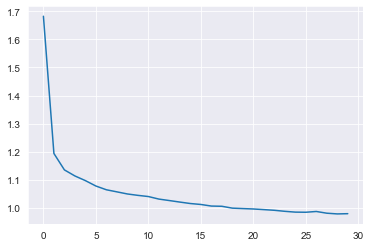

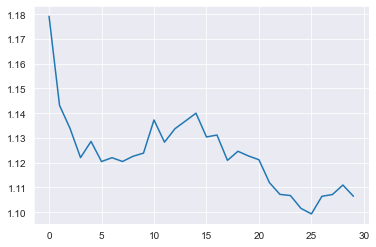

In [148]:
sns.set_style("darkgrid")
plt.plot(history['loss'])
plt.show()
plt.plot(history['loss_test'])
plt.show()

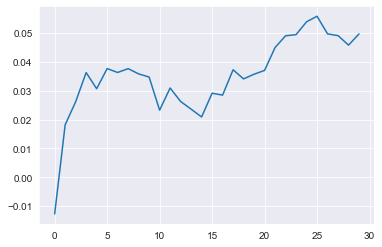

In [145]:
sns.set_style("darkgrid")
plt.plot(history['r2_score_test'])
plt.show()

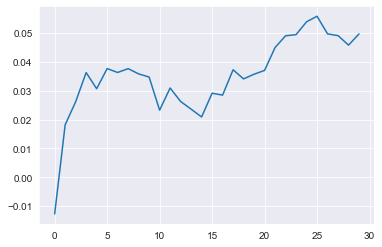

In [146]:
sns.set_style("darkgrid")
plt.plot(history['r2_score_train'])
plt.show()